In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare the data

Data were loaded and cleaned. The cleaning process included getting rid of the punctuation marks and converting the texts into lower case.

In [2]:
import string

titles = pd.read_csv("./data/medium_post_titles.csv")
titles.drop(columns=["subtitle", "subtitle_truncated_flag"], inplace=True)

titles.title = titles.title.str.replace('[{}]'.format(string.punctuation), '').str.lower()
titles.title = titles.title.str.replace('‘', '')
titles.title = titles.title.str.replace('’', '')
titles.title = titles.title.str.replace('“', '')
titles.title = titles.title.str.replace('”', '')
titles.title = titles.title.str.replace('—', '')

titles.head()

,category,title
0,work,21 conversations a fun and easy game for team...
1,spirituality,biblical porn at mars hill
2,lgbtqia,cisgender is that a disease
3,equality,call me nat love black cowboys and the frontie...
4,artificial-intelligence,can i train my model on your computer


20% of the data were held out for testing.

In [3]:
from sklearn.model_selection import train_test_split

titles_train, titles_test = train_test_split(titles, train_size=0.8, stratify=titles.category.values)

X_train = titles_train.title.values
X_test = titles_test.title.values

y_train = titles_train.category.values
y_test = titles_test.category.values

In [4]:
import warnings
warnings.filterwarnings('ignore')

The theme labels were converted to one hot representations.

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

integer_encoder = LabelEncoder()
integer_train = integer_encoder.fit_transform(y_train).reshape((-1, 1))
integer_test = integer_encoder.transform(y_test).reshape((-1, 1))

onehot_encoder = OneHotEncoder(sparse=False)
onehot_train = onehot_encoder.fit_transform(integer_train)
onehot_test = onehot_encoder.transform(integer_test)

# Tokenization and vectorization

Use TF-IDF to perform bag-of-words vetorization.

We adopted the Penn Treebank Tokenizer. We did not want to include n-grams because it will significantly increase the size of the vocabulary. Terms that appear less than twice or occur in more than 10% of the docuemnts are rejected. This choice is made based on experience extracting features for a naive Bayes model.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TreebankWordTokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

tokenizer = TreebankWordTokenizer()
vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize, ngram_range=(1, 1), stop_words='english', min_df=2, max_df=0.1)

XMatrix_train = vectorizer.fit_transform(X_train)
vocabulary = np.array(vectorizer.get_feature_names())

XMatrix_test = vectorizer.transform(X_test)

In [7]:
vocabularySize = vocabulary.size
print("Number of terms in the vocabulary: {}".format(vocabularySize))

Number of terms in the vocabulary: 22411


# Multilayer perceptron network

## 2 hidden layers, 256, 256

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from time import time
from keras.models import load_model

layer1 = Dense(256, activation="relu", input_dim=vocabularySize)
layer2 = Dense(256, activation="relu")
outputLayer = Dense(93, activation="softmax")
classifier = Sequential([layer1, layer2, outputLayer])
classifier.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["acc"])

early_stopping = EarlyStopping(monitor="val_acc", mode="max", patience=50, min_delta=1, verbose=2)
best_model_saving = ModelCheckpoint("MLP_best_model.h5", monitor="val_acc", mode="max", save_best_only=True, verbose=2)

start_time = time()
history = classifier.fit(XMatrix_train,onehot_train, epochs=5000, batch_size=2048, validation_data=(XMatrix_test,onehot_test), callbacks=[early_stopping, best_model_saving], verbose=2)
end_time = time()
print("Time elapsed during training: {}".format(end_time - start_time))

classifier = load_model("MLP_best_model.h5")
_, train_accuracy = classifier.evaluate(XMatrix_train, onehot_train, verbose=0)
print("Accuracy on training set: {}".format(train_accuracy))
_, test_accuracy = classifier.evaluate(XMatrix_test, onehot_test, verbose=0)
print("Accuracy on held-out test set: {}".format(test_accuracy))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 101134 samples, validate on 25284 samples
Epoch 1/5000
 - 52s - loss: 4.2217 - acc: 0.0653 - val_loss: 3.9134 - val_acc: 0.1469

Epoch 00001: val_acc improved from -inf to 0.14693, saving model to MLP_best_model.h5
Epoch 2/5000
 - 47s - loss: 3.4283 - acc: 0.2511 - val_loss: 3.0038 - val_acc: 0.3248

Epoch 00002: val_acc improved from 0.14693 to 0.32475, saving model to MLP_best_model.h5
Epoch 3/5000
 - 49s - loss: 2.4651 - acc: 0.4292 - val_loss: 2.5466 - val_acc: 0.3890

Epoch 00003: val_acc improved from 0.32475 to 0.38898, saving model to MLP_best_model.h5
Epoch 4/5000
 - 50s - loss: 1.9328 - acc: 0.5296 - val_loss: 2.4745 - val_acc: 0.4084

Epoch 00004: val_acc improved from 0.38898 to 0.40840, saving model to MLP_best_model.h5
Epoch 5/5000
 - 49s - loss: 1.6216 - acc: 0.5962 - val_loss: 2.5061 - val_acc: 0.4050

Epoch 00005: val_acc did not improve from

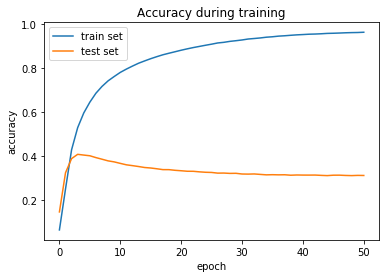

In [9]:
def plotFittingAccuracy(history):
    
    plt.plot(history.history['acc'], label='train set')
    plt.plot(history.history['val_acc'], label='test set')
    
    plt.title("Accuracy during training")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend()
    plt.show()
    
plotFittingAccuracy(history)

# Precision-recall

In [10]:
probability = classifier.predict_proba(XMatrix_test)
classList = integer_encoder.classes_

In [11]:
realLabel = np.equal(np.repeat(np.reshape(y_test, (-1, 1)), len(classList), axis=1), np.repeat(np.reshape(classList, (1, -1)), len(y_test), axis=0))
thresholds = np.arange(0, 1.001, 0.001)
precision = np.zeros((len(thresholds), len(classList)))
recall = np.zeros((len(thresholds), len(classList)))

for i, threshold in enumerate(thresholds):
    predictedLabel = probability >= threshold

    truePoz = (predictedLabel & realLabel).sum(axis = 0)
    falsePoz = (predictedLabel & (realLabel == False)).sum(axis = 0)
    falseNeg = ((predictedLabel == False) & realLabel).sum(axis = 0)

    precision[i, :] = truePoz / (truePoz + falsePoz)
    recall[i, :] = truePoz / (truePoz + falseNeg)
    
averagePrecision = np.nanmean(precision, axis=1)
averageRecall = np.nanmean(recall, axis=1)
minPrecision = np.nanmin(precision, axis=1)
maxPrecision = np.nanmax(precision, axis=1)

Text(0, 0.5, 'precision')

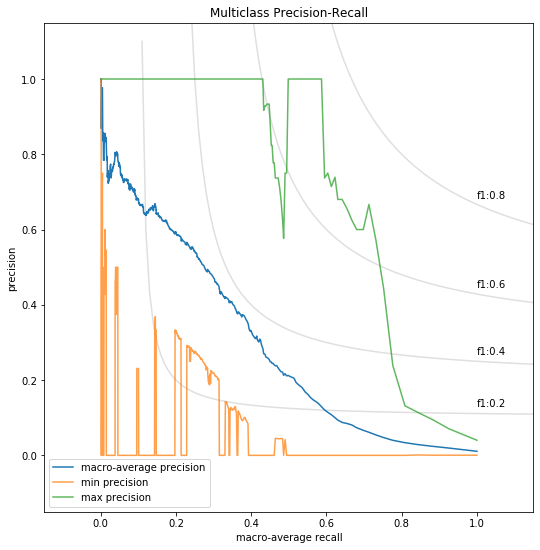

In [12]:
plt.figure(figsize=(9,9))

f_scores = np.linspace(0.2, 0.8, num=4)
for f_score in f_scores:
    x = np.linspace(0.01, 1.15, 115)
    y = f_score * x / (2 * x - f_score)
    plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.25)
    plt.annotate('f1:{0:0.1f}'.format(f_score), xy=(1, y[100] + 0.02))

plt.plot(averageRecall, averagePrecision, label="macro-average precision")
plt.plot(averageRecall, minPrecision, label="min precision", alpha=0.75)
plt.plot(averageRecall, maxPrecision, label="max precision", alpha=0.75)

plt.xlim([-.15, 1.15])
plt.ylim([-.15, 1.15])
plt.gca().set_aspect('equal')
plt.legend(loc="lower left")
plt.title("Multiclass Precision-Recall")
plt.xlabel("macro-average recall")
plt.ylabel("precision")

In [13]:
maxProbability = probability.max(axis=1)
classifiedProportion = np.zeros(len(thresholds))
for i, threshold in enumerate(thresholds):
    classifiedProportion[i] = (maxProbability >= threshold).sum() / len(maxProbability)

Text(0.5, 1.0, 'Precision & Recall')

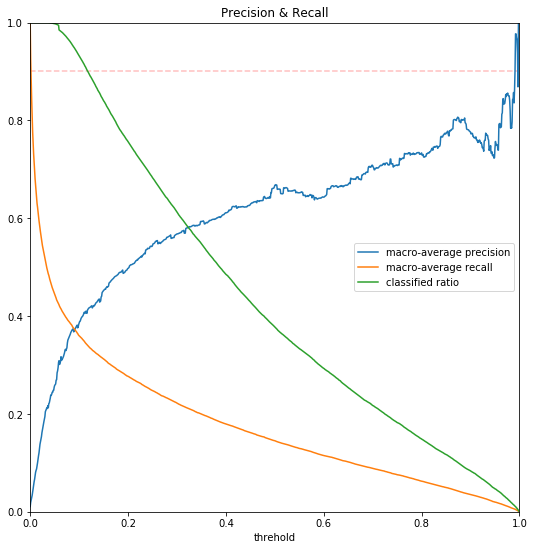

In [14]:
plt.figure(figsize=(9,9))

plt.axhline(0.9, color="red",linestyle='dashed', alpha=0.25)
plt.plot(thresholds, averagePrecision, label="macro-average precision")
plt.plot(thresholds, averageRecall, label="macro-average recall")
plt.plot(thresholds, classifiedProportion, label="classified ratio")

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.gca().set_aspect('equal')
plt.legend(loc="center right")
plt.xlabel("threhold")
plt.title("Precision & Recall")

In [15]:
threshold90 = thresholds[averagePrecision >= 0.9].min()
recall90 = averageRecall[threshold90 == thresholds][0]
print("To reach a multiclass average precision more than 90%, the minimum threshold is " + str(threshold90) + "; the corresponding multiclass average recall is " + str(recall90) + ".")

To reach a multiclass average precision more than 90%, the minimum threshold is 0.991; the corresponding multiclass average recall is 0.005150820092056718.
